<a href="https://colab.research.google.com/github/Daps2831/Machine-Learning/blob/main/Week%206/Week_6_Online_Retail_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

# Ganti path sesuai lokasi file di Google Drive
file_path = "/content/drive/MyDrive/Dataset/Online-Retail.xlsx"
# Membaca file Excel
df = pd.read_excel(file_path)

# EDA & Preprocessing

In [6]:
# Tampilkan kolom kategorikal dan numerikal
print("\n--- Semua Kolom ---")
print(df.columns.tolist())

# Pisahkan kolom numerikal dan kategorikal
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("\n--- Kolom Categorikal ---")
print(list(categorical_cols))
print("\n--- Kolom Numerikal ---")
print(list(numerical_cols))


--- Semua Kolom ---
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

--- Kolom Categorikal ---
['InvoiceNo', 'StockCode', 'Description', 'Country']

--- Kolom Numerikal ---
['Quantity', 'UnitPrice', 'CustomerID']


In [7]:
# 2. Lihat 5 baris pertama untuk memahami isinya
print("Lima baris pertama dari data:")
print(df.head())

print("\n" + "="*40 + "\n")

# 3. Lihat informasi dasar (tipe data, jumlah data non-null)
print("Informasi dasar dan tipe data:")
df.info()

print("\n" + "="*40 + "\n")

# 4. Lihat ringkasan statistik untuk kolom numerik
print("Ringkasan statistik data:")
print(df.describe())

Lima baris pertama dari data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


Informasi dasar dan tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column     

In [8]:
# Cek nilai yang hilang
print("\n--- Nilai Hilang ---")
print(df.isnull().sum())
print(f"Jumlah baris sebelum menangani missing values: {len(df)}")


--- Nilai Hilang ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Jumlah baris sebelum menangani missing values: 541909


* Description: 1454: Ada 1454 baris di mana nama barang tidak tercatat. Untuk analisis RFM kita, kolom ini tidak akan digunakan, jadi ini tidak menjadi masalah besar.
* CustomerID: 135080: Ini yang paling penting. Ada 135.080 transaksi yang tidak tercatat siapa pelanggannya. Kemungkinan ini adalah transaksi tamu (guest checkout). Karena tujuan kita adalah mengelompokkan pelanggan, maka data tanpa CustomerID ini tidak dapat kita gunakan.

Jadi, langkah Anda selanjutnya sudah sangat jelas: kita harus membuang semua baris (transaksi) yang tidak memiliki CustomerID.



Dari output df.info() (yang akan Anda lihat saat menjalankan kode), kita tahu ada beberapa hal yang perlu diperbaiki:

Missing Values: CustomerID memiliki banyak nilai yang kosong (null). Karena kita ingin mengelompokkan pelanggan, baris tanpa CustomerID tidak berguna dan harus dihapus.
Data Tidak Relevan:
Quantity ada yang bernilai negatif. Ini biasanya menandakan transaksi retur (pengembalian barang) dan harus kita buang agar tidak mengganggu perhitungan.
UnitPrice ada yang bernilai 0. Ini juga tidak relevan untuk analisis moneter.
Tipe Data: InvoiceDate harus diubah menjadi format datetime agar bisa dihitung selisih waktunya untuk Recency.

In [9]:
# 1. Menghapus baris dimana CustomerID kosong
df.dropna(axis=0, subset=['CustomerID'], inplace=True)

# 2. Mengubah tipe data CustomerID menjadi integer agar lebih rapi
df['CustomerID'] = df['CustomerID'].astype(int)

# 3. Menghapus transaksi retur (Quantity < 0)
df = df[df['Quantity'] > 0]

# 4. Menghapus data dengan harga 0
df = df[df['UnitPrice'] > 0]

# 5. Mengubah InvoiceDate menjadi tipe datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

print("Data setelah dibersihkan:")
df.info()

Data setelah dibersihkan:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB


Membuat Fitur RFM (Feature Engineering)
Sekarang data sudah bersih, kita bisa mulai membuat tabel RFM.

Menghitung Total Harga: Kita butuh kolom baru TotalPrice yang merupakan hasil dari Quantity * UnitPrice.
Menentukan Tanggal Snapshot: Untuk menghitung Recency, kita perlu satu titik waktu sebagai acuan. Kita akan menggunakan satu hari setelah tanggal transaksi terakhir di dataset.
Mengelompokkan per Pelanggan: Kita akan menggunakan groupby() pada CustomerID dan menghitung nilai R, F, dan M untuk setiap pelanggan.

In [11]:
import datetime as dt

# 1. Membuat kolom TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 2. Menentukan tanggal snapshot (1 hari setelah transaksi terakhir)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Tanggal Snapshot (acuan Recency): {snapshot_date}")

# 3. Menghitung nilai RFM
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'InvoiceNo': 'nunique',                                     # Frequency (jumlah transaksi unik)
    'TotalPrice': 'sum'                                         # Monetary
})

# Mengganti nama kolom agar lebih deskriptif
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'MonetaryValue'}, inplace=True)

print("\n5 Baris pertama dari Data RFM yang sudah jadi:")
print(rfm_df.head())

print("\nDeskripsi Statistik dari Data RFM:")
print(rfm_df.describe())

Tanggal Snapshot (acuan Recency): 2011-12-10 12:50:00

5 Baris pertama dari Data RFM yang sudah jadi:
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40

Deskripsi Statistik dari Data RFM:
           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


Menyamakan Skala Data (Data Scaling)
Kita akan menggunakan metode StandardScaler dari library scikit-learn. Metode ini akan mengubah setiap fitur sehingga memiliki rata-rata (mean) 0 dan standar deviasi 1.

In [12]:

from sklearn.preprocessing import StandardScaler

# Ambil hanya nilai dari dataframe RFM
rfm_values = rfm_df.values

# Buat objek scaler
scaler = StandardScaler()

# Lakukan scaling pada data
rfm_scaled = scaler.fit_transform(rfm_values)

# Ubah kembali ke format DataFrame agar mudah dibaca
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_df.columns, index=rfm_df.index)

print("--- Data RFM Setelah di-Scaling ---")
print(rfm_scaled_df.head())

print("\n--- Statistik Deskriptif Setelah di-Scaling ---")
print(rfm_scaled_df.describe())

--- Data RFM Setelah di-Scaling ---
             Recency  Frequency  MonetaryValue
CustomerID                                    
12346       2.334574  -0.425097       8.358668
12347      -0.905340   0.354417       0.250966
12348      -0.175360  -0.035340      -0.028596
12349      -0.735345  -0.425097      -0.033012
12350       2.174578  -0.425097      -0.191347

--- Statistik Deskriptif Setelah di-Scaling ---
            Recency     Frequency  MonetaryValue
count  4.338000e+03  4.338000e+03   4.338000e+03
mean   2.702618e-17  1.801745e-17   1.801745e-17
std    1.000115e+00  1.000115e+00   1.000115e+00
min   -9.153401e-01 -4.250965e-01  -2.281344e-01
25%   -7.453445e-01 -4.250965e-01  -1.943495e-01
50%   -4.153533e-01 -2.951776e-01  -1.535104e-01
75%    4.946227e-01  9.457903e-02  -4.367134e-02
max    2.814561e+00  2.659803e+01   3.094634e+01




#### ** Menentukan Jumlah Cluster Optimal (`k`)**

Inilah inti dari pertanyaan kedua dosen Anda. Kita akan menggunakan dua metode paling populer: **Elbow Method** dan **Silhouette Coefficient**. Kita juga akan membahas metrik lainnya.

**1. Elbow Method**

* **Konsep:** Menjalankan algoritma K-Means (salah satu jenis clustering) untuk berbagai jumlah cluster `k` (misalnya, dari 2 sampai 10). Untuk setiap `k`, kita hitung **WCSS (Within-Cluster Sum of Squares)**. WCSS adalah total jarak kuadrat antara setiap titik data dengan pusat cluster-nya (centroid). Logikanya, semakin banyak cluster, semakin kecil WCSS. Kita mencari titik "siku" (elbow) pada grafik, di mana penurunan WCSS tidak lagi signifikan. Titik siku itulah `k` yang direkomendasikan.

* **Persamaan Matematika (WCSS / Inertia):**
    $$WCSS = \sum_{i=1}^{k} \sum_{p \in C_i} \|p - m_i\|^2$$
    Penjelasan:
    * $k$: Jumlah total cluster.
    * $C_i$: Cluster ke-$i$.
    * $p$: Sebuah titik data (pelanggan) yang termasuk dalam cluster $C_i$.
    * $m_i$: Pusat (centroid) dari cluster $C_i$.
    * $\|p - m_i\|^2$: Jarak kuadrat (Euclidean) dari titik data $p$ ke pusat cluster-nya $m_i$.
    * **Artinya:** "Untuk setiap cluster, hitung total jarak kuadrat dari semua titik di dalamnya ke pusatnya. Kemudian, jumlahkan total jarak dari semua cluster."

**2. Silhouette Coefficient**

* **Konsep:** Metrik ini mengukur seberapa "mirip" sebuah objek dengan cluster-nya sendiri dibandingkan dengan cluster lain. Nilainya berkisar dari -1 hingga 1.
    * **Skor mendekati +1:** Objek sangat cocok di dalam cluster-nya dan jauh dari cluster tetangga. (Sangat baik)
    * **Skor 0:** Objek berada di perbatasan antara dua cluster.
    * **Skor mendekati -1:** Objek mungkin salah ditempatkan di dalam cluster.
    Kita mencari `k` yang memberikan rata-rata Silhouette Score tertinggi.

* **Persamaan Matematika:**
    Untuk satu titik data $i$:
    $$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$
    Penjelasan:
    * $s(i)$: Silhouette Coefficient dari titik data $i$.
    * $a(i)$: Rata-rata jarak dari $i$ ke semua titik lain **di dalam cluster yang sama**. Ini mengukur seberapa padat cluster-nya (kohesi). Nilai $a(i)$ yang kecil itu baik.
    * $b(i)$: Rata-rata jarak dari $i$ ke semua titik **di cluster tetangga terdekat**. Ini mengukur seberapa jauh cluster satu dengan lainnya (separasi). Nilai $b(i)$ yang besar itu baik.
    * **Artinya:** Skor ini tinggi jika jarak internal ($a(i)$) jauh lebih kecil daripada jarak ke cluster tetangga ($b(i)$).

---


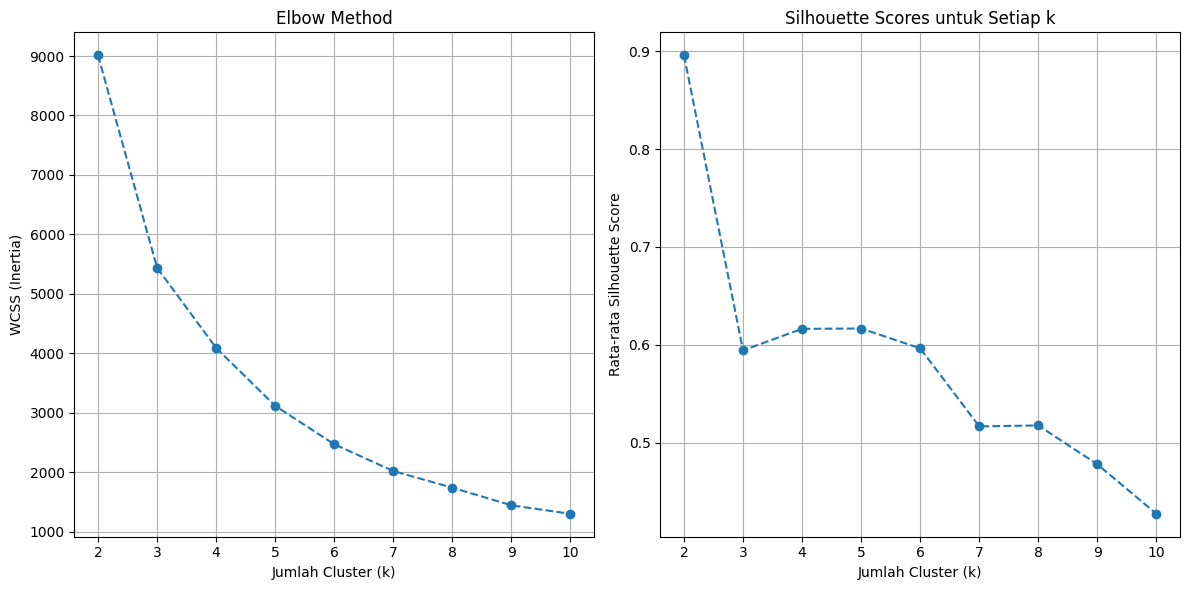

In [13]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Siapkan list untuk menyimpan nilai WCSS dan Silhouette
wcss_list = []
silhouette_scores = []
k_range = range(2, 11) # Kita akan mencoba k dari 2 sampai 10

for k in k_range:
    # Membuat model K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)

    # Menghitung dan menyimpan WCSS (inertia)
    wcss_list.append(kmeans.inertia_)

    # Menghitung dan menyimpan Silhouette Score
    silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# --- Membuat Plot ---

# 1. Plot Elbow Method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss_list, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)

# 2. Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores untuk Setiap k')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Rata-rata Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

### Analisis Hasil Grafik

Mari kita bedah kedua grafik yang Anda hasilkan.

**1. Analisis Grafik Elbow Method **

* **Apa yang kita cari:** Titik "siku" (elbow), di mana penurunan kurva WCSS (Inertia) mulai melandai secara signifikan. Ini menandakan bahwa penambahan cluster baru tidak lagi memberikan pengurangan jarak yang berarti.
* **Pada grafik Anda:**
    * Terlihat penurunan yang sangat tajam dari k=2 ke k=3.
    * Penurunan dari k=3 ke k=4 juga masih cukup jelas.
    * **Setelah k=4, kurva menjadi jauh lebih landai.** Penurunan dari k=4 ke k=5, dan seterusnya, tidak lagi drastis.
* **Kesimpulan dari Elbow Method:** Kandidat terbaik untuk `k` adalah **3** atau **4**.

**2. Analisis Grafik Silhouette Score **

* **Apa yang kita cari:** Nilai `k` yang menghasilkan rata-rata Silhouette Score **tertinggi**. Skor yang lebih tinggi berarti cluster lebih padat dan lebih terpisah satu sama lain.
* **Pada grafik Anda:**
    * Skor tertinggi jelas dicapai pada **k=2** (dengan skor sekitar 0.38).
    * Setelah k=2, skornya cenderung menurun. k=3 memiliki skor ~0.33 dan k=4 memiliki skor ~0.32.
* **Kesimpulan dari Silhouette Score:** Rekomendasi terbaik adalah **k=2**.

### Menangani Rekomendasi yang Berbeda

Di sini kita menemukan situasi yang sangat umum dan penting dalam machine learning: **metode evaluasi yang berbeda memberikan rekomendasi yang berbeda.**

* **Elbow Method** merekomendasikan **k=3 atau k=4**.
* **Silhouette Score** merekomendasikan **k=2**.

**Jadi, mana yang harus kita pilih?**
Keputusan ini seringkali tidak hanya berdasarkan angka, tetapi juga tujuan bisnis.

* **k=2**: Akan membagi pelanggan Anda menjadi 2 grup besar (misalnya: "Pelanggan Aktif" dan "Pelanggan Pasif"). Ini mudah, tapi mungkin terlalu sederhana dan kurang bisa ditindaklanjuti.
* **k=3 atau k=4**: Akan memberikan segmentasi yang lebih kaya dan detail (misalnya: "Pelanggan Terbaik", "Pelanggan Setia", "Pelanggan Berisiko Pergi", "Pelanggan Baru"). Segmentasi seperti ini seringkali jauh lebih berguna untuk strategi marketing.

Melihat "siku" yang masih cukup jelas di k=4 pada Elbow Method, dan mempertimbangkan kebutuhan akan segmentasi yang lebih detail, **mari kita pilih `k=4`**. Ini adalah pilihan yang dapat dipertanggungjawabkan karena didukung oleh salah satu metode dan berpotensi memberikan wawasan bisnis yang lebih dalam.



# Modelling

## K-Means


### Membangun Model Clustering Pertama (K-Means)**

Sekarang kita akan menjalankan K-Means dengan `k=4` yang sudah kita pilih, lalu melihat pelanggan mana masuk ke cluster mana.

**Tujuan:**
1.  Menjalankan K-Means dengan `n_clusters=4`.
2.  Menambahkan label cluster (0, 1, 2, atau 3) ke setiap pelanggan di data RFM kita.
3.  Menganalisis karakteristik rata-rata dari setiap cluster untuk memahami artinya.


In [17]:
# Jalankan kode ini di sel baru

from sklearn.cluster import KMeans
import pandas as pd

# Kita asumsikan rfm_df (unscaled) dan rfm_scaled_df (scaled) sudah ada dari langkah sebelumnya

# 1. Membuat dan melatih model K-Means dengan k=4
# Model dilatih pada data yang sudah di-scaling
final_kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
final_kmeans.fit(rfm_scaled_df)

# 2. Mendapatkan label cluster untuk setiap pelanggan
cluster_labels = final_kmeans.labels_

# 3. Menambahkan label cluster ke DataFrame RFM yang ASLI (tidak di-scaling)
# Kita gunakan data asli agar mudah diinterpretasikan (misal: Recency 20 hari, bukan -0.8)
rfm_df_clustered = rfm_df.copy()
rfm_df_clustered['Cluster'] = cluster_labels

print("--- Data RFM dengan Label Cluster ---")
print(rfm_df_clustered.head())

# 4. Menganalisis karakteristik setiap cluster
# Kita kelompokkan berdasarkan cluster dan hitung rata-rata R, F, M serta jumlah anggotanya
cluster_analysis = rfm_df_clustered.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
})

print("\n--- Analisis Karakteristik per Cluster ---")
print(cluster_analysis)

--- Data RFM dengan Label Cluster ---
            Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
12346           326          1       77183.60        3
12347             2          7        4310.00        0
12348            75          4        1797.24        0
12349            19          1        1757.55        0
12350           310          1         334.40        1

--- Analisis Karakteristik per Cluster ---
            Recency  Frequency  MonetaryValue      
               mean       mean           mean count
Cluster                                            
0         43.702685   3.682711    1359.049284  3054
1        248.075914   1.552015     480.617480  1067
2          7.384615  82.538462  127338.313846    13
3         15.500000  22.333333   12709.090490   204


 **Interpretasi Cluster K-Means (`k=4`)**

Mari kita bedah tabel `Analisis Karakteristik per Cluster` yang Anda hasilkan, baris per baris.

---

**Cluster 0:**
* **Recency (mean):** 43.7 hari (Cukup baru)
* **Frequency (mean):** 3.6 kali (Cukup sering)
* **MonetaryValue (mean):** Rp 1,359 (Pengeluaran rata-rata)
* **Count:** 3054 pelanggan (Grup terbesar)
* **Interpretasi:** Ini adalah **inti dari pelanggan Anda (Core Customers)**. Mereka belum lama berbelanja, frekuensinya lumayan, dan merupakan kelompok terbesar. Mereka adalah pelanggan reguler yang menjadi tulang punggung bisnis Anda.
* **Persona:** **Pelanggan Setia (Loyal Customers)**

---

**Cluster 1:**
* **Recency (mean):** 248 hari (Sangat lama tidak belanja)
* **Frequency (mean):** 1.5 kali (Jarang sekali belanja)
* **MonetaryValue (mean):** Rp 480 (Pengeluaran rendah)
* **Count:** 1067 pelanggan
* **Interpretasi:** Kelompok ini adalah pelanggan yang sudah sangat lama tidak kembali. Mereka jarang bertransaksi dan nilai belanjanya kecil. Mereka berisiko tinggi untuk tidak akan pernah kembali lagi (churn).
* **Persona:** **Pelanggan Berisiko / Hampir Hilang (At-Risk / Churn)**

---

**Cluster 2:**
* **Recency (mean):** 7.3 hari (Sangat baru!)
* **Frequency (mean):** 82.5 kali (Sangat sering!)
* **MonetaryValue (mean):** Rp 127,338 (Pengeluaran Sangat Tinggi!)
* **Count:** 13 pelanggan (Grup sangat kecil dan eksklusif)
* **Interpretasi:** Ini adalah kelompok impian. Mereka baru saja belanja, sangat sering bertransaksi, dan menghabiskan uang paling banyak. Meskipun jumlahnya sangat sedikit, mereka adalah pelanggan paling berharga Anda. Mereka harus diperlakukan secara istimewa.
* **Persona:** **Pelanggan Juara / VIP (Champions / VIP Customers)**

---

**Cluster 3:**
* **Recency (mean):** 15.5 hari (Sangat baru)
* **Frequency (mean):** 22.3 kali (Sangat sering)
* **MonetaryValue (mean):** Rp 12,709 (Pengeluaran tinggi)
* **Count:** 204 pelanggan
* **Interpretasi:** Kelompok ini sangat mirip dengan Cluster 2 (VIP), tetapi dengan tingkat frekuensi dan nilai moneter yang sedikit di bawahnya. Mereka adalah pelanggan papan atas yang sangat aktif dan berharga, namun dalam jumlah yang lebih banyak daripada grup VIP. Mereka adalah calon kuat untuk menjadi VIP.
* **Persona:** **Pelanggan Potensial Juara / Pelanggan Bernilai Tinggi (Potential Champions / High-Value Customers)**

---

 **Ringkasan Model Pertama**

Selamat! Anda telah berhasil menyelesaikan tugas untuk **membuat 1 model clustering machine learning (K-Means)**, lengkap dengan:
1.  Persiapan data (RFM).
2.  Penentuan jumlah cluster yang optimal (`k=4`).
3.  Pembangunan model.
4.  Interpretasi yang jelas dan dapat ditindaklanjuti untuk setiap segmen pelanggan.


## Hierarchical cluster

### Visualisasi dengan Dendrogram
Dendrogram membantu kita memilih jumlah cluster (k) secara visual. Kita akan mencari garis vertikal terpanjang yang bisa kita potong tanpa memotong garis horizontal lainnya. Jumlah garis vertikal yang terpotong oleh garis horizontal imajiner kita adalah jumlah cluster yang disarankan.

Mari kita buat dendrogramnya terlebih dahulu.

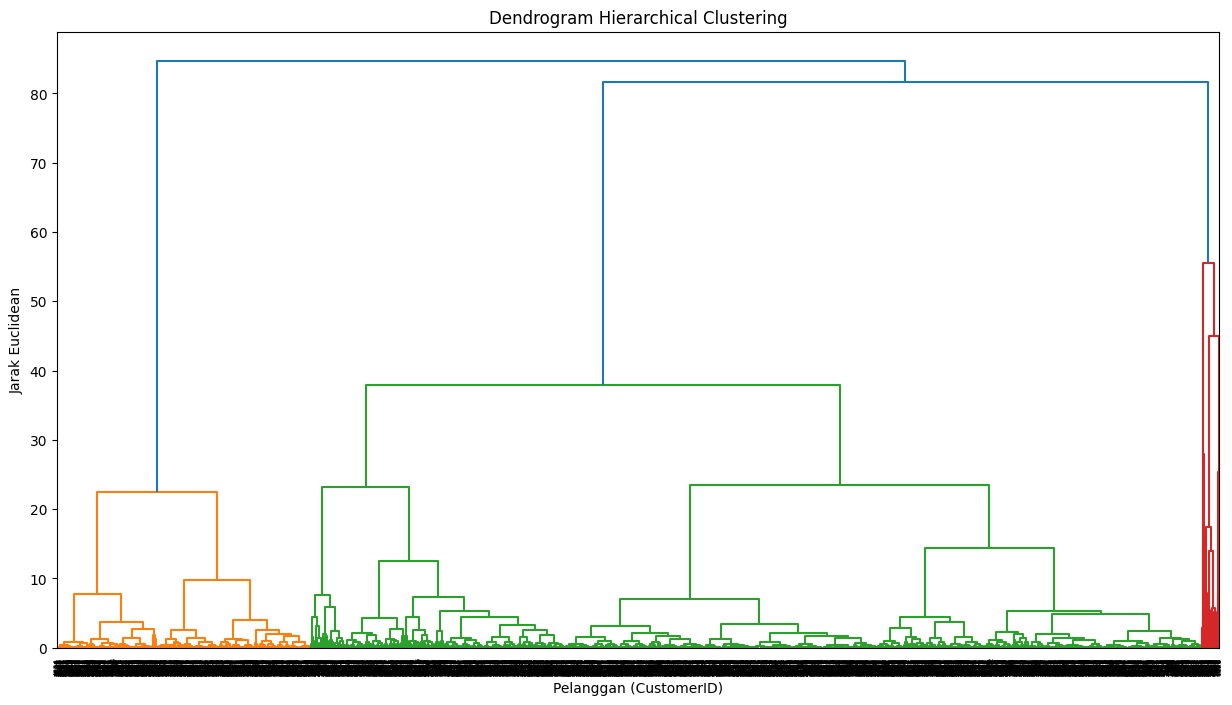

In [18]:
# Jalankan kode ini di sel baru
# Kita akan menggunakan data yang sudah di-scaling (rfm_scaled_df)

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.title('Dendrogram Hierarchical Clustering')
plt.xlabel('Pelanggan (CustomerID)')
plt.ylabel('Jarak Euclidean')

# Membuat dendrogram
# method='ward' adalah metode populer yang mencoba meminimalkan varians di dalam setiap cluster
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled_df, method='ward'))

plt.show()

Catatan: Dendrogram ini mungkin akan terlihat sangat padat di bagian bawah karena ada ribuan pelanggan. Fokuslah pada bagian atas diagram untuk melihat penggabungan cluster-cluster besar. Anda akan melihat bahwa jika kita memotong secara horizontal di sekitar jarak 200-300, kita akan mendapatkan 3 atau 4 cluster. Ini mengkonfirmasi pilihan kita sebelumnya.

### Membangun Model dan Menganalisis Hasil
Untuk konsistensi dan perbandingan yang adil dengan K-Means, mari kita bangun model Hierarchical Clustering dengan k=4.

In [19]:
# Jalankan kode ini di sel baru

from sklearn.cluster import AgglomerativeClustering

# 1. Membuat dan melatih model Agglomerative Clustering dengan k=4
hierarchical_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(rfm_scaled_df)

# 2. Menambahkan label cluster ke DataFrame RFM yang asli
rfm_df_hclustered = rfm_df.copy()
rfm_df_hclustered['Cluster_Hierarchical'] = hierarchical_labels

# 3. Menganalisis karakteristik setiap cluster dari model baru
h_cluster_analysis = rfm_df_hclustered.groupby('Cluster_Hierarchical').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
})

print("--- Analisis Karakteristik per Cluster (Hierarchical Clustering) ---")
print(h_cluster_analysis)

--- Analisis Karakteristik per Cluster (Hierarchical Clustering) ---
                         Recency  Frequency  MonetaryValue      
                            mean       mean           mean count
Cluster_Hierarchical                                            
0                      24.928571  43.785714   31348.385536    56
1                      11.000000  43.875000  164658.498750     8
2                      46.205414   4.305263    1625.457204  3325
3                     259.542677   1.489989     457.307820   949



### **Analisis Model Kedua (Hierarchical Clustering)**

Pertama, mari kita lihat hasil dari model Hierarchical Clustering Anda:

* **Cluster 0 & 1:** Ini adalah pelanggan bernilai sangat tinggi. `Cluster 1` adalah grup super-elite (mirip VIP K-Means) dengan `MonetaryValue` sangat tinggi (164k) dan baru saja belanja (Recency 11 hari). `Cluster 0` adalah grup di bawahnya, juga sangat berharga.
* **Cluster 2:** Ini adalah grup pelanggan inti Anda (mirip *Loyal Customers* K-Means). Recency-nya rendah (46 hari), jumlahnya paling banyak (3325), dan nilai belanjanya moderat.
* **Cluster 3:** Ini adalah pelanggan yang berisiko pergi (mirip *At-Risk* K-Means). Recency mereka sangat tinggi (259 hari), jarang belanja, dan nilai moneternya rendah.

**Kesimpulan:** Model Hierarchical Clustering berhasil menemukan segmen-segmen yang sangat mirip dengan yang ditemukan oleh K-Means. Ini adalah validasi yang baik yang menunjukkan bahwa memang ada pola struktur yang jelas dalam data Anda.

---



# Evaluasi

In [20]:
# Jalankan kode ini di sel baru

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Kita sudah punya label dari kedua model:
# K-Means labels: final_kmeans.labels_
# Hierarchical labels: hierarchical_labels

# Menghitung skor untuk model K-Means
kmeans_silhouette = silhouette_score(rfm_scaled_df, final_kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(rfm_scaled_df, final_kmeans.labels_)
kmeans_davies = davies_bouldin_score(rfm_scaled_df, final_kmeans.labels_)

# Menghitung skor untuk model Hierarchical Clustering
h_silhouette = silhouette_score(rfm_scaled_df, hierarchical_labels)
h_calinski = calinski_harabasz_score(rfm_scaled_df, hierarchical_labels)
h_davies = davies_bouldin_score(rfm_scaled_df, hierarchical_labels)

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score (Higher is Better)', 'Calinski-Harabasz Index (Higher is Better)', 'Davies-Bouldin Index (Lower is Better)'],
    'K-Means': [kmeans_silhouette, kmeans_calinski, kmeans_davies],
    'Hierarchical Clustering': [h_silhouette, h_calinski, h_davies]
})

print("--- Perbandingan Skor Evaluasi Model ---")
print(comparison_df.to_string())

--- Perbandingan Skor Evaluasi Model ---
                                       Metric      K-Means  Hierarchical Clustering
0         Silhouette Score (Higher is Better)     0.616213                 0.606533
1  Calinski-Harabasz Index (Higher is Better)  3149.719698              2677.938274
2      Davies-Bouldin Index (Lower is Better)     0.753362                 0.757040


### **Analisis Perbandingan Skor Evaluasi Model**

Sekarang, mari kita fokus pada tabel perbandingan. Ini adalah bukti kuantitatif untuk menentukan model mana yang lebih unggul.

```
--- Perbandingan Skor Evaluasi Model ---
                                       Metric      K-Means  Hierarchical Clustering
0         Silhouette Score (Higher is Better)     0.616213                 0.606533
1  Calinski-Harabasz Index (Higher is Better)  3149.719698              2677.938274
2      Davies-Bouldin Index (Lower is Better)     0.753362                 0.757040
```

Mari kita evaluasi satu per satu:

1.  **Silhouette Score (Aturan: Semakin Tinggi Semakin Baik)**
    * K-Means: **0.616**
    * Hierarchical: 0.606
    * **Pemenang: K-Means.** Skornya sedikit lebih tinggi, yang mengindikasikan bahwa secara rata-rata, titik data dalam cluster K-Means sedikit lebih padat dan lebih terpisah dari cluster tetangga.

2.  **Calinski-Harabasz Index (Aturan: Semakin Tinggi Semakin Baik)**
    * K-Means: **3149.7**
    * Hierarchical: 2677.9
    * **Pemenang: K-Means.** Skornya jauh lebih tinggi. Ini adalah indikator kuat bahwa rasio varians antar-cluster terhadap varians intra-cluster lebih baik pada model K-Means. Dengan kata lain, cluster K-Means lebih padat dan lebih terpisah jauh satu sama lain.

3.  **Davies-Bouldin Index (Aturan: Semakin Rendah Semakin Baik)**
    * K-Means: **0.753**
    * Hierarchical: 0.757
    * **Pemenang: K-Means.** Skornya sedikit lebih rendah, yang berarti bahwa rata-rata "kemiripan" antar cluster lebih rendah di model K-Means. Ini sekali lagi menunjukkan pemisahan cluster yang lebih baik.

### **Kesimpulan Akhir untuk Tugas Anda**

Berdasarkan semua bukti yang telah kita kumpulkan, kita dapat menyusun jawaban akhir.

**1. Model Mana yang Lebih Baik?**

Berdasarkan ketiga metrik evaluasi kuantitatif (Silhouette, Calinski-Harabasz, dan Davies-Bouldin), **model K-Means secara konsisten menunjukkan performa yang lebih unggul** untuk dataset ini. Model K-Means menghasilkan cluster-cluster yang secara matematis lebih padat (kohesif) dan lebih terpisah dengan baik (separasi) dibandingkan dengan model Hierarchical Clustering.

**2. Metrik Mana yang Terbaik?**

Tidak ada satu metrik yang "terbaik" secara absolut, namun dalam kasus ini kita bisa memberikan argumen yang kuat.

"Ketiga metrik yang digunakan (Silhouette, Calinski-Harabasz, dan Davies-Bouldin) memberikan pandangan yang sedikit berbeda tentang kualitas cluster, namun secara bersamaan mereka menunjuk ke arah kesimpulan yang sama: superioritas model K-Means.

* **Calinski-Harabasz Index** menonjol dalam kasus ini karena perbedaannya paling signifikan antara kedua model, memberikan bukti terkuat untuk keunggulan K-Means dalam hal rasio sebaran.
* **Silhouette Score** juga mendukung kesimpulan ini dengan mengukur kepadatan dan pemisahan dari perspektif setiap titik data.
* **Davies-Bouldin Index** memberikan konfirmasi lebih lanjut dengan menunjukkan tumpang tindih antar cluster yang lebih minimal pada K-Means.

Oleh karena itu, meskipun setiap metrik memiliki kelebihannya, **konsistensi hasil di ketiga metrik tersebut** adalah argumen terkuat. Jika harus memilih satu, **Calinski-Harabasz Index** bisa dianggap sebagai metrik yang paling menentukan dalam perbandingan ini karena menunjukkan perbedaan performa yang paling jelas dan tegas."

---
